In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement
import pcl
import cv2
from cv2 import aruco

# # HELIOS
# filename = "HELIOS\CALIB_HELIOS_09.ply"
# imsize, f = (640, 480), 526.771469 
# MED_FILL = True
# SHARPEN = False

# SICK
imsize, f = (512, 424), 330.
filename = "SICK\CALIB_SICK_06.ply"
MED_FILL = False
SHARPEN = True

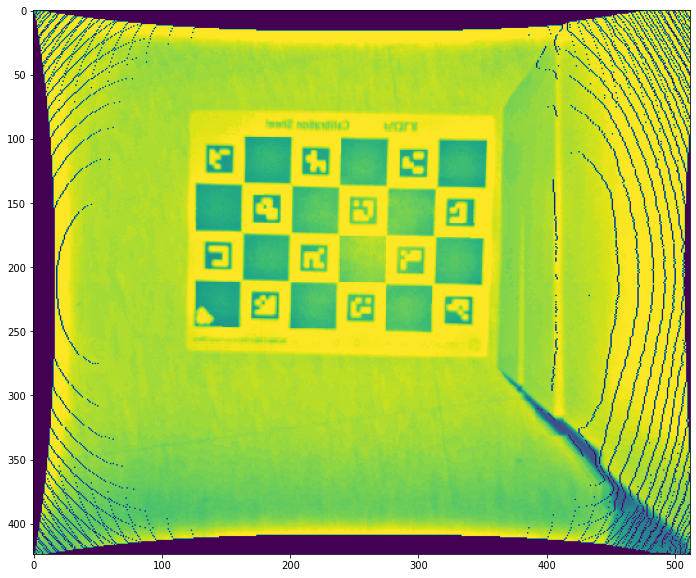

In [2]:
ply_dat = PlyData.read(filename)
vertex = ply_dat.elements[0]
verts = np.array([dat.tolist() for dat in vertex.data])

dictionary = aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
board = cv2.aruco.CharucoBoard_create(4, 6, 0.04, 0.024, dictionary)

camK = np.identity(3) * f
camK[2,2] = 1
camK[:2,2] = np.divide(imsize, 2)
distortion = np.array([0.0]*5)
pxy1 = np.matmul(verts[:,:3], camK.transpose()) / verts[:,2:3]

image = np.zeros(imsize).transpose()
pass_count = 0
for (px, py, _), color in zip(pxy1, np.max(verts[:, 3:], axis=-1)):
    if (imsize[0]-0.5 > px > -0.5) and (imsize[1]-0.5 > py > -0.5):
        image[round(py), round(px)] = color
        pass_count += 1
image = (image/np.max(image)*255).astype(np.uint8)
if MED_FILL:
    median = cv2.medianBlur(image,5)
    image[np.where(image==0)] = median[np.where(image==0)]

if SHARPEN:
    sigma, gamma = 10, 1
    blur = cv2.GaussianBlur(image, (0, 0), sigma)
    image = cv2.addWeighted(image, 1 + gamma, blur, -gamma, 0)

plt.figure(figsize=(20,10))
plt.imshow(image)

ids: [17]
ch_ids: [17]


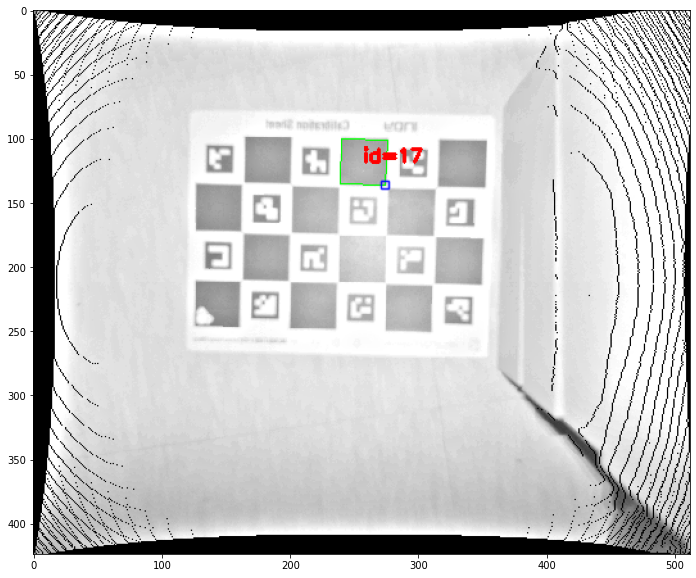

In [3]:
corners, ids, _ = aruco.detectMarkers(image, dictionary)

print("ids: {}".format(np.array(ids).flatten()))

img_cp = np.stack([image, image, image], axis=-1).copy()
img_cp = aruco.drawDetectedMarkers(img_cp, corners, ids)

ret, ch_corners, ch_ids = aruco.interpolateCornersCharuco(corners, ids, image, board)
print("ch_ids: {}".format(np.array(ids).flatten()))

aruco.drawDetectedCornersCharuco(img_cp, ch_corners, ch_ids, (255,0,0))

rvec = np.array((3,1))
tvec = np.array((3,1))
retval, rvec, tvec = aruco.estimatePoseCharucoBoard(ch_corners, ch_ids, board,
                                                    camK, distortion, None, None)
if retval:
    cv2.drawFrameAxes(img_cp, camK, distortion, rvec, tvec, 0.08);
    
plt.figure(figsize=(20,10))
plt.imshow(img_cp)